In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
from pathlib import Path
import statistics as st

In [2]:
# import
path = Path(kagglehub.dataset_download("ahmedabbas757/coffee-sales"))/"Coffee Shop Sales.xlsx"
records = pd.read_excel(path, index_col="transaction_id")

In [3]:
# transform
transaction_datetime = pd.to_datetime(records["transaction_date"].astype(str) + " " + records["transaction_time"].astype(str))
transaction_datetime = pd.Series(transaction_datetime, name="transaction_datetime",index=None)

records = records.reindex([
    "transaction_datetime", 'transaction_qty', 'store_id', 
    'store_location', 'product_id', 'unit_price', 
    'product_category', 'product_type', 'product_detail'], axis="columns")

records["transaction_datetime"] = transaction_datetime
records.sort_values("transaction_datetime", inplace=True)

columns = ["store_location","product_category","product_type", "product_detail"]
records[columns] = records.loc[:,columns].astype("category")

records.head()

,transaction_datetime,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
transaction_id,,,,,,,,,
1,2023-01-01 07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
2,2023-01-01 07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
3,2023-01-01 07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
4,2023-01-01 07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
5,2023-01-01 07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


---
**How does the average monthly transaction quantity vary across different store locations,\
and which location exhibits the highest variance in sales volume?**

In [4]:
agg_data = (records
            .groupby(["store_location",records["transaction_datetime"].dt.month], observed=True)["transaction_qty"]
            .mean()
            .unstack()
            .round(2)
            .T
           )
agg_data.index = pd.Index(["Jan", "Feb", "Mar", "Apr", "May", "Jun"],name="month")

store_location
Astoria            0.000067
Hell's Kitchen     0.000067
Lower Manhattan    0.000040
dtype: float64

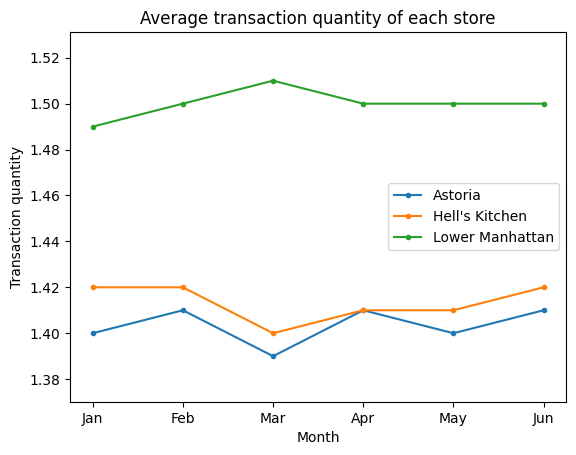

In [5]:
# charting
ax = plt.subplot()
ax.plot(agg_data, label=agg_data.columns,marker=".")
ax.legend()
ax.set_ylim(ax.get_ylim()[0]*0.99,ax.get_ylim()[1]*1.01)
ax.set_title("Average transaction quantity of each store")
ax.set_xlabel("Month")
ax.set_ylabel("Transaction quantity")
agg_data.agg("var")
# The transaction quantities show close to no change over the months and all stay in a very small band (small variance)

---
**What is the median unit price for each product category,\
and how do the interquartile ranges compare across categories?**

In [6]:
quartiles = records.groupby("product_category",observed=True)["unit_price"].quantile([0.25,0.5,0.75]).unstack()

print("Median unit price for each product category:")
quartiles[0.5]

Median unit price for each product category:


product_category
Bakery                 3.50
Branded               14.00
Coffee                 3.00
Coffee beans          19.75
Drinking Chocolate     4.50
Flavours               0.80
Loose Tea              8.95
Packaged Chocolate     7.60
Tea                    2.55
Name: 0.5, dtype: float64

In [7]:
print("Interquantile ranges compared:")
(quartiles[0.75] - quartiles[0.25]).sort_values()
# some products exibit no price variation accross types and over time (flavours), while other (branded) have a wide price range

Interquantile ranges compared:


product_category
Flavours               0.00
Loose Tea              0.30
Bakery                 0.50
Tea                    0.50
Drinking Chocolate     1.00
Coffee                 1.05
Packaged Chocolate     5.73
Coffee beans           6.00
Branded               16.00
dtype: float64

---
**Are there any outliers in the transaction quantities based on the IQR method?**

In [8]:
groups = records.groupby("product_category", observed=True, as_index=False)["transaction_qty"]
data = {}

for category, srs in groups:
    data.update({category:srs.array})

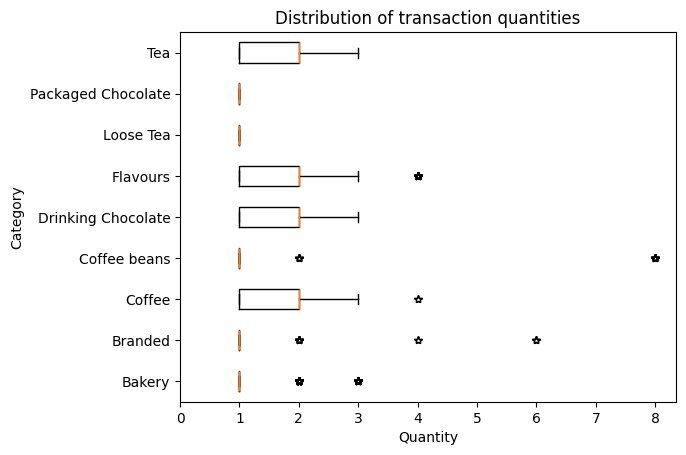

In [9]:
# charting
fig, ax = plt.subplots()
ax.boxplot(data.values(), orientation="horizontal", tick_labels=data.keys(), sym="*")
ax.set_title("Distribution of transaction quantities")
ax.set_xlim(0)
ax.set_xlabel("Quantity")
ax.set_ylabel("Category");

---
**What is the distribution of total sales per hour of the day,\
and at what time do stores experience the highest and lowest median sales?**

In [10]:
revenue = pd.Series(records["unit_price"] * records["transaction_qty"],name="revenue")
revenue.index = pd.Index(records["transaction_datetime"])

In [11]:
mean_revenue = (revenue
                .groupby([revenue.index.date, revenue.index.hour])
                .sum()
                .unstack()
                .median(axis="rows")
               )

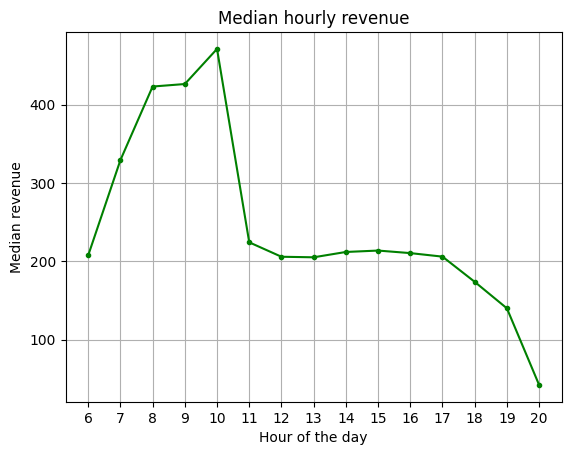

In [12]:
# charting
ax = plt.subplot()
ax.plot(mean_revenue,color="green",marker=".")
ax.set_xticks(range(6,21))
ax.grid()
ax.set_title("Median hourly revenue")
ax.set_ylabel("Median revenue")
ax.set_xlabel("Hour of the day");

---
**How do sales fluctuate by day of the week,\
and which weekday has the highest standard deviation in transaction quantities?**

In [13]:
weeks = records["transaction_datetime"].dt.isocalendar()["week"].to_numpy()
# correcting the first week of the year from 52 to 1
weeks = np.where(weeks==52,1,weeks)
days = records["transaction_datetime"].dt.weekday.to_numpy()

daily_revenue = revenue.groupby([weeks, days]).sum().unstack()
daily_revenue.index.name = "week"
daily_revenue.columns.name = "day"

daily_deviation = daily_revenue.std(axis="rows")
daily_median_revenue = daily_revenue.median(axis="rows")

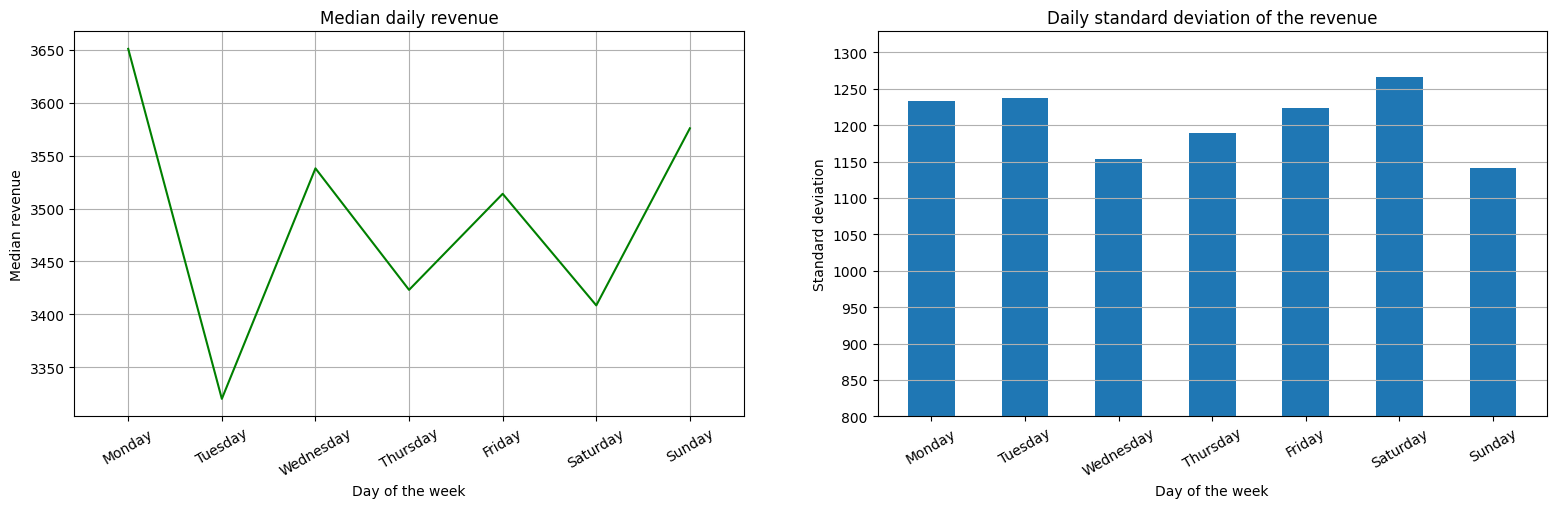

In [14]:
# charting
fig, (line, bar) = plt.subplots(1,2,sharex=True, figsize=(19,5))

# line setting
line.plot(daily_median_revenue,color="green")
line.set_xticks(range(7))
line.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=30)
line.grid()
line.set_title("Median daily revenue")
line.set_xlabel("Day of the week")
line.set_ylabel("Median revenue")

# bar setting
bar.bar(range(7), daily_deviation,width=0.5)
bar.grid(axis="y")
bar.set_xticks(range(7))
bar.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=30)
bar.set_ylim(800)
bar.set_yticks(range(800,1301,50))
bar.set_title("Daily standard deviation of the revenue")
bar.set_xlabel("Day of the week")
bar.set_ylabel("Standard deviation");

---
**What is the trend in total revenue over time—does it exhibit any seasonal patterns or anomalies?**

In [15]:
# todo: make weeks dynamic
grouped_revenue = revenue.groupby(weeks).sum()

first_week_of_month = (records
                       .groupby(records["transaction_datetime"].dt.month)
                       .first()["transaction_datetime"]
                       .dt
                       .isocalendar()["week"]
                       .to_numpy()
                      )
first_week_of_month = np.where(first_week_of_month==52,1,first_week_of_month)
first_week_of_month = pd.Series(["January","February", "March", "April", "May", "June"],index=first_week_of_month)

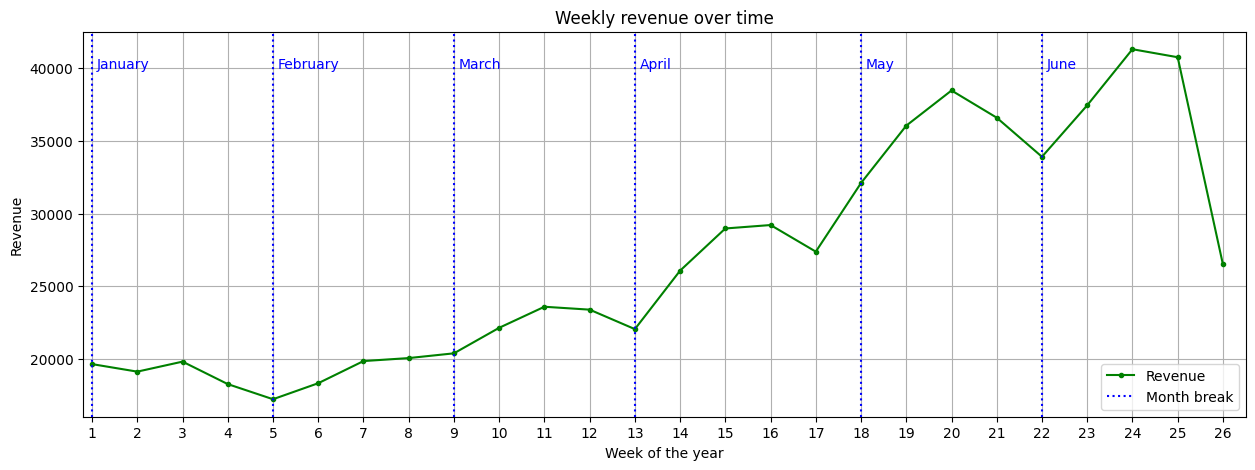

In [16]:
# charting
legend = False
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(grouped_revenue,color="green",marker=".",label="Revenue")
ax.set_xticks(range(1,27))
ax.set_xlim(weeks[0]-0.2,weeks[-1]+0.5)
ax.set_title("Weekly revenue over time")
ax.set_xlabel("Week of the year")
ax.set_ylabel("Revenue")
ax.grid()

for week, month_name in first_week_of_month.items():
    ax.axvline(
        x=week,
        color="blue",
        linestyle="dotted",
        label="Month break"
    )

    ax.text(
        x=week+0.1,
        y=40000,
        s=month_name,
        color="blue"
    )

    if not legend:
        ax.legend()
        legend = True

---
**What is the coefficient of variation (CV) in transaction quantities across different store locations,\
and which store shows the most consistent sales performance?**

In [17]:
stddev = records.groupby("store_location",observed=True)["transaction_qty"].std()
mean = records.groupby("store_location",observed=True)["transaction_qty"].mean()

cv_coefficient = stddev / mean

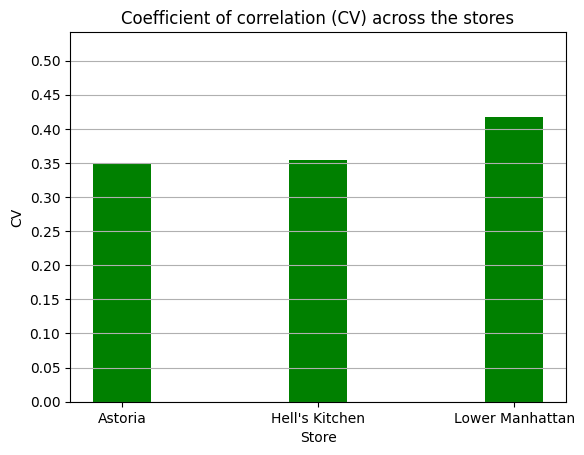

In [18]:
# charting
ax = plt.subplot()
ax.bar(
    x=cv_coefficient.index, 
    height=cv_coefficient.to_numpy(),
    width=0.3,
    color="green"
)
ax.set_ylim(0,cv_coefficient.max()*1.3)
ax.set_yticks(
    np.arange(0,cv_coefficient.max()*1.3,0.05)
)
ax.set_title("Coefficient of correlation (CV) across the stores")
ax.set_xlabel("Store")
ax.set_ylabel("CV")
ax.grid(axis="y")

---
**How does the total revenue per store compare,\
and which store is the top performer in terms of both mean and median monthly revenue?**

In [43]:
def get_monthly_revenue(df:pd.DataFrame) -> pd.Series:
    rev = df["transaction_qty"] * df["unit_price"]
    return rev.groupby(df["transaction_datetime"].dt.month).sum()
    
total_monthly_revenue = (records
                        .groupby("store_location",observed=True)
                        .apply(get_monthly_revenue,include_groups=False)
                        .T
                       )

total_revenue = total_monthly_revenue.sum(axis="rows")

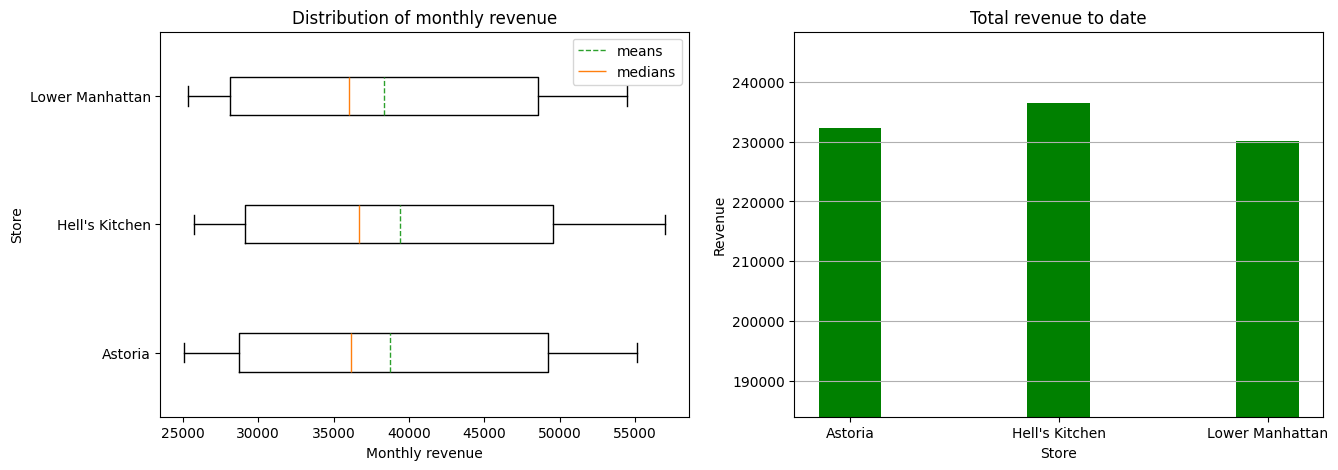

In [64]:
# charting
fig, (box, bar) = plt.subplots(ncols=2,figsize=(15,5))

# boxplots
axes = box.boxplot(
    x=total_monthly_revenue,
    orientation="horizontal",
    tick_labels=total_monthly_revenue.columns,
    meanline=True,
    showmeans=True
)
box.legend([axes["means"][0], axes["medians"][0]], ["means","medians"])
box.set_title("Distribution of monthly revenue")
box.set_ylabel("Store")
box.set_xlabel("Monthly revenue")

# bars
bar.bar(
    x=total_revenue.index,
    height=total_revenue.array,
    width=0.3,
    color="green"
)
bar.set_title("Total revenue to date")
bar.set_xlabel("Store")
bar.set_ylabel("Revenue");
bar.set_ylim(total_revenue.min()*0.8,total_revenue.max()*1.05);
bar.grid(axis="y");

---
**Which store has the highest average transaction value,\
and is there a significant difference between the top and bottom performers?**

In [73]:
mean_trans_value = records.groupby("store_location",observed=True).apply(
    lambda df: (df["unit_price"] * df["transaction_qty"]).mean(),
    include_groups=False
)

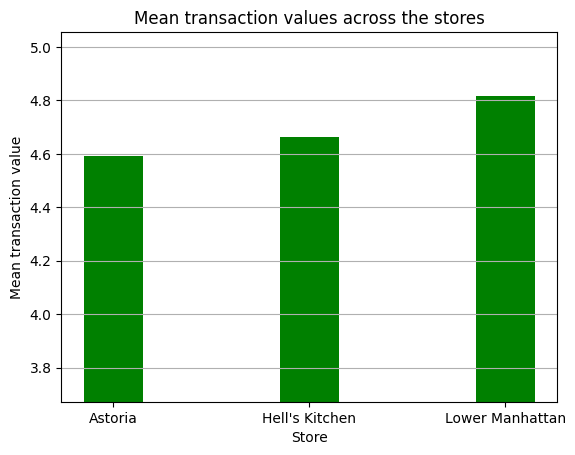

In [78]:
# charting
ax = plt.subplot()
ax.bar(
    x=mean_trans_value.index,
    height=mean_trans_value.array,
    width=0.3,
    color="green"
)
ax.set_title("Mean transaction values across the stores")
ax.set_xlabel("Store")
ax.set_ylabel("Mean transaction value")
ax.set_ylim(mean_trans_value.min()*0.8,mean_trans_value.max()*1.05);
ax.grid(axis="y");